<a href="https://colab.research.google.com/github/BalakumaranR05/Complex-adding-machine-using-Neural-net/blob/main/FNN_sum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
# Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
# To Create a function for create datasets
def create_data(data_size, r1,r2):
  data = (r1 - r2) * torch.rand(data_size, 3) + r2
  data[:,2] = data[:,0] + data[:,1]

  X = data[:,:2] 
  y = data[:,2]

  # Resizing to column vector
  y = y[:,None]
  
  # Spliting into train and test
  X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2)

  train_data = TensorDataset(X_train,y_train)
  test_data = TensorDataset(X_test,y_test)

  # Converting into DataLoader objects
  train_loader = DataLoader(train_data, batch_size = 20, drop_last=True, shuffle=True)
  test_loader = DataLoader(test_data, batch_size= test_data.tensors[0].shape[0])

  return train_loader, test_loader

In [95]:
def create_net():
  
  class FNN_net(nn.Module):
    def __init__(self):
      super().__init__()

      # Model archeiture with hidden layers
      self.input = nn.Linear(2,10)
      self.fc1 = nn.Linear(10,4)
      self.output = nn.Linear(4,1)


    def forward(self,x):
      
      # Foward pass
      x = F.relu(self.input(x))
      x = F.relu(self.fc1(x))

      return self.output(x)
  
  sum_net = FNN_net()
  # Loss function
  loss_func = nn.MSELoss()
  # Optimizer - SGD
  optimizer = torch.optim.Adam(sum_net.parameters(), lr=0.0001)

  return sum_net, loss_func,optimizer

In [97]:
# Testing the model archieture created

net = create_net()[0]
data = torch.rand((10,2))
yHat = net(data)

yHat

tensor([[0.4483],
        [0.4362],
        [0.4522],
        [0.4509],
        [0.4054],
        [0.4019],
        [0.4124],
        [0.4316],
        [0.4488],
        [0.4076]], grad_fn=<AddmmBackward0>)

In [113]:
def train_net(data_size):

  sum_net, loss_func, optimizer = create_net()

  train_loader, test_loader = create_data(data_size,-20,20)

  numepochs = 200
  trainAcc = []
  testAcc = []
  losses = []

  for epoch in range(numepochs):
    batchAcc = []
    batchLoss = []

    for X,y in train_loader:

      yHat = sum_net(X)
      loss = loss_func(yHat,y)

      # For calucating Batch Accuracy
      
      batchAcc.append(100*torch.mean( (torch.abs(yHat-y)<1).float() ))

      # Appending batch losses
      batchLoss.append(loss.detach())

      # Back prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # End of Batch
    
    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))


    X,y = next(iter(test_loader))

    with torch.no_grad():
      yHat = sum_net(X)
      loss = loss_func(yHat,y)
    
    testAcc.append(100*torch.mean( (torch.abs(yHat-y)<1).float()))

  return losses, trainAcc, testAcc

In [102]:
data_size = np.arange(10,2111,50)
accuracy_array = np.zeros((len(data_size),2))


for i in range(len(data_size)):
  losses, trainAcc, testAcc = train_net(data_size[i])
  accuracy_array[i,0] = np.mean(trainAcc[-20:])
  accuracy_array[i,1] = np.mean(testAcc[-20:])

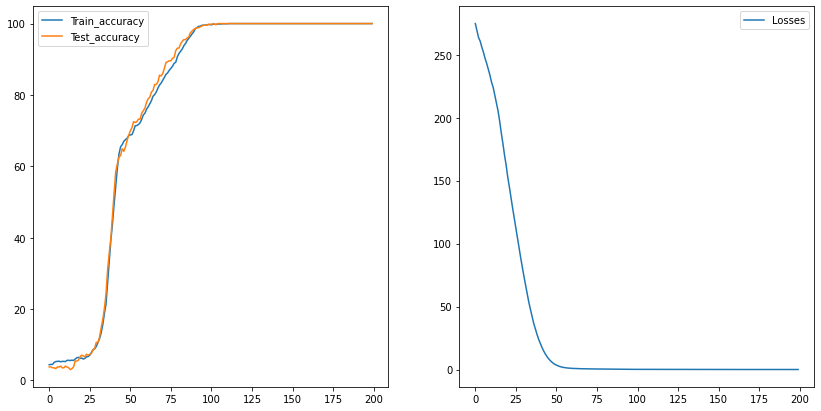

In [112]:
fig, ax = plt.subplots(1,2,figsize=(14,7))

ax[0].plot(trainAcc, label='Train_accuracy')
ax[0].plot(testAcc, label ='Test_accuracy')
ax[0].legend()

ax[1].plot(losses, label ='Losses')
ax[1].legend()

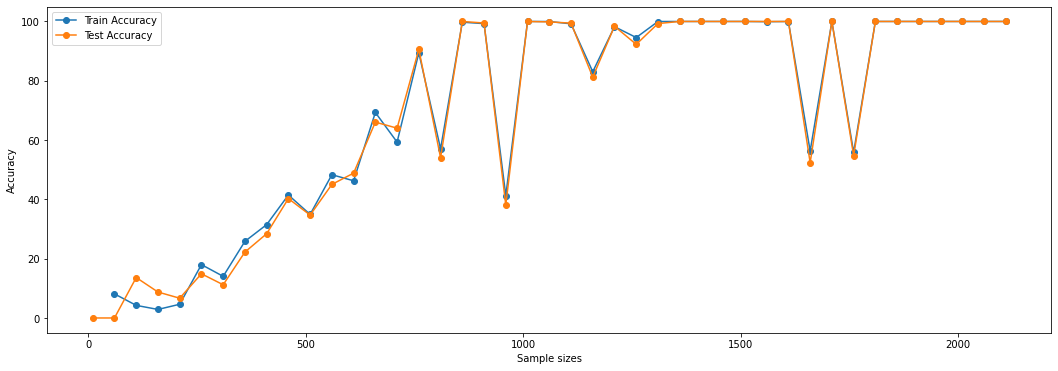

In [110]:
plt.figure(figsize=(18,6))

plt.plot(data_size, accuracy_array[:,0],'o-', label = 'Train Accuracy')
plt.plot(data_size, accuracy_array[:,1], 'o-', label = 'Test Accuracy')

plt.xlabel("Sample sizes")
plt.ylabel('Accuracy')
plt.legend()